# **1. Loading & Cleaning Data**

In [1]:
import yfinance as yf

gold_ticker = yf.Ticker("GC=F")

df = gold_ticker.history(period="1y", interval='1h')

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

display(df.shape)

display(df.head(3))

(5767, 4)

,Open,High,Low,Close
Datetime,,,,
2023-09-21 00:00:00-04:00,1948.300049,1948.500000,1947.699951,1947.800049
2023-09-21 01:00:00-04:00,1947.800049,1948.800049,1946.800049,1948.500000
2023-09-21 02:00:00-04:00,1948.400024,1950.300049,1947.400024,1948.099976


# **Loading constants needed**

In [2]:
import json

with open('prams.json', 'r') as file:
    data = json.load(file)

WINDOW, PNL, SIGNALS, PRICE_DEVIATION, POSITIONS_NATURE, POSITIONS_SHORTCUT = data['WINDOW'], data['PNL'], data['SIGNALS'], data['PRICE_DEVIATION'], data['POSITIONS_NATURE'], data['POSITIONS_SHORTCUT']

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [3]:
# Low
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

df.dropna(inplace=True)
df.reset_index(inplace=True)

display(df.head(3))

,Datetime,Open,High,Low,Close,Mean_L,STD_L,Z-Score_L,Mean_H,STD_H,Z-Score_H
0,2023-09-21 06:00:00-04:00,1944.400024,1945.900024,1943.500000,1945.199951,1945.128557,2.453387,-0.663800,1947.728585,1.941416,-0.941870
1,2023-09-21 07:00:00-04:00,1945.000000,1945.300049,1939.800049,1940.400024,1944.000000,2.857157,-1.469976,1947.271449,2.099780,-0.938860
2,2023-09-21 08:00:00-04:00,1940.400024,1940.400024,1933.400024,1936.000000,1942.085711,4.616055,-1.881626,1946.071446,3.195160,-1.775004


### Overview

<Axes: ylabel='Z-Score'>

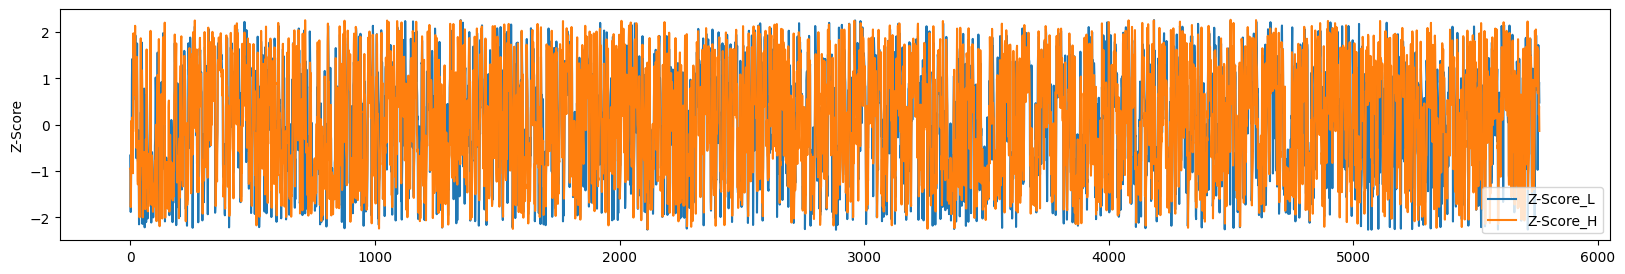

In [4]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', figsize=(20, 3), ylabel="Z-Score")

,Z-Score_L,Z-Score_H
max,2.258415,2.265128
min,-2.264885,-2.253621


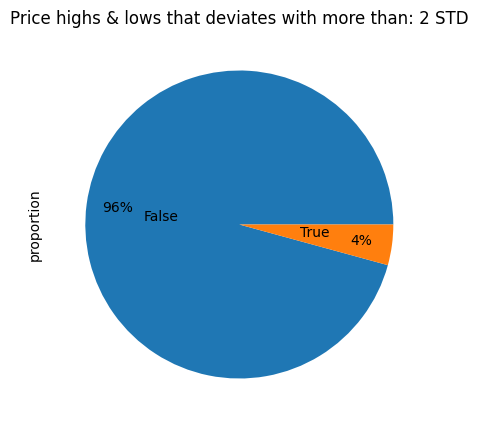

In [5]:
# same for Z-Score_H
stats = (abs(df['Z-Score_L']) > PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)

stats.plot(
    kind='pie', 
    figsize=(5, 5),
    title=f"Price highs & lows that deviates with more than: {PRICE_DEVIATION['ENTRY']} STD",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.4
)

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [6]:
df['Signal'] = 0  # Default to hold/no position
df.loc[df['Z-Score_L'] < -PRICE_DEVIATION['ENTRY'], 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[df['Z-Score_H'] > PRICE_DEVIATION['ENTRY'], 'Signal']= SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

# **3. Implementing Stop Loss and Take Profit**

In [7]:
from helpers import Trade

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

def check_buy_sl(i: int):
    if df.loc[i, 'Low'] <= trade.sl:  # SL hit
        df.loc[i, 'Exit_Price'] = trade.sl
        df.loc[i, 'PnL'] = PNL['LOSS']
        trade.Off()  # Exit trade

def check_buy_tp(i: int, source='Close'):
    if df.loc[i, source] > trade.tp:  # TP hit
        df.loc[i, 'Exit_Price'] = trade.tp
        df.loc[i, 'PnL'] = PNL['WIN']
        trade.Off()  # Exit trade

def check_sell_sl(i: int):
    if df.loc[i, 'High'] >= trade.sl:  # SL hit
        df.loc[i, 'Exit_Price'] = trade.sl
        df.loc[i, 'PnL'] = PNL['LOSS']
        trade.Off()  # Exit trade

def check_sell_tp(i: int, source='Close'):
    if df.loc[i, source] < trade.tp:  # TP hit
        df.loc[i, 'Exit_Price'] = trade.tp
        df.loc[i, 'PnL'] = PNL['WIN']
        trade.Off()  # Exit trade

# check sl first then make sure trade is on to check tp

def check_buy_trade(i: int):
    check_buy_sl(i)
    if trade.on: check_buy_tp(i, 'High')

def check_sell_trade(i: int):
    check_sell_sl(i)
    if trade.on: check_sell_tp(i, 'Low')

def fill_trade_params(_row, idx):
    sig = _row['Signal']
    L_H = POSITIONS_SHORTCUT[str(sig)]
    mean_kw, std_kw = f"Mean_{L_H}", f"STD_{L_H}"
    trade.On()
    trade.entry = (_row[mean_kw] - sig * PRICE_DEVIATION['ENTRY'] * _row[std_kw])
    trade.tp = (_row[mean_kw] - sig * PRICE_DEVIATION['TP'] * _row[std_kw])
    trade.sl = (_row[mean_kw] - sig * PRICE_DEVIATION['SL'] * _row[std_kw])
    df.loc[idx, ['Position', 'Entry_Price']] = [sig, trade.entry]

    # check if sl or tp is already hit in the same candel (i)
    if sig == SIGNALS['BUY']:
        check_buy_sl(idx)
        if trade.on: check_buy_tp(idx)
    
    if sig == SIGNALS['SELL']:
        check_sell_sl(idx)
        if trade.on: check_sell_tp(idx)

for i, row in df.iterrows(): # row for reading, i for writing
    if trade.on: 
        # Track price movement for Stop Loss or Take Profit
        if trade.is_buy: check_buy_trade(i)
        if trade.is_sell: check_sell_trade(i)
    else:
        # Check if there's a signal
        if row['Signal'] != 0:
            fill_trade_params(row, i)

# **4. Backtesting & Overview**

In [8]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
win_rate = trades['PnL'].value_counts(normalize=True).loc[1]

print(f"Total Trades: {total_trades}")
print(f"Total Profit/Loss: {total_pnl} RR")
print(f"Win rate: {round(win_rate, 3) * 100}%")

Total Trades: 279
Total Profit/Loss: 157.0 RR
Win rate: 78.10000000000001%


- **PnL**

<Axes: title={'center': 'PnL'}, xlabel='Datetime', ylabel='RR | %'>

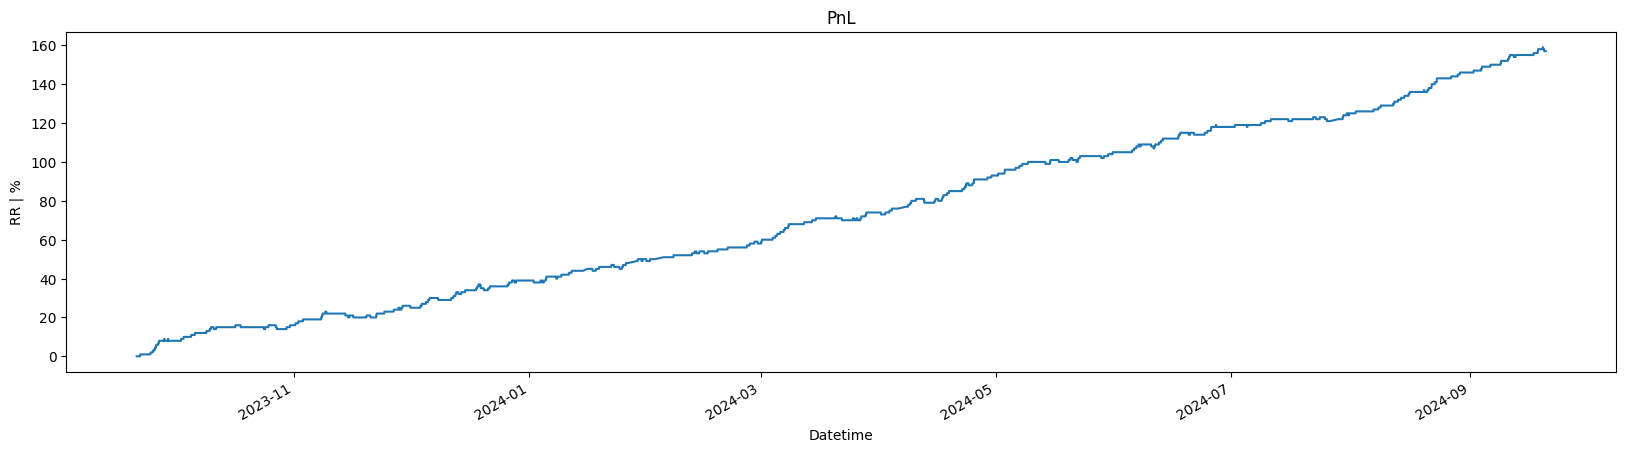

In [9]:
df.set_index('Datetime', inplace=True)

df['Cumulative_PnL'].plot(
    kind='line', 
    figsize=(20, 5), 
    title="PnL",
    ylabel="RR | %",
)

- **PnL-Drawdown** (not from Equity)

<Axes: title={'center': 'PnL-Drawdown'}, xlabel='Datetime', ylabel='RR | %'>

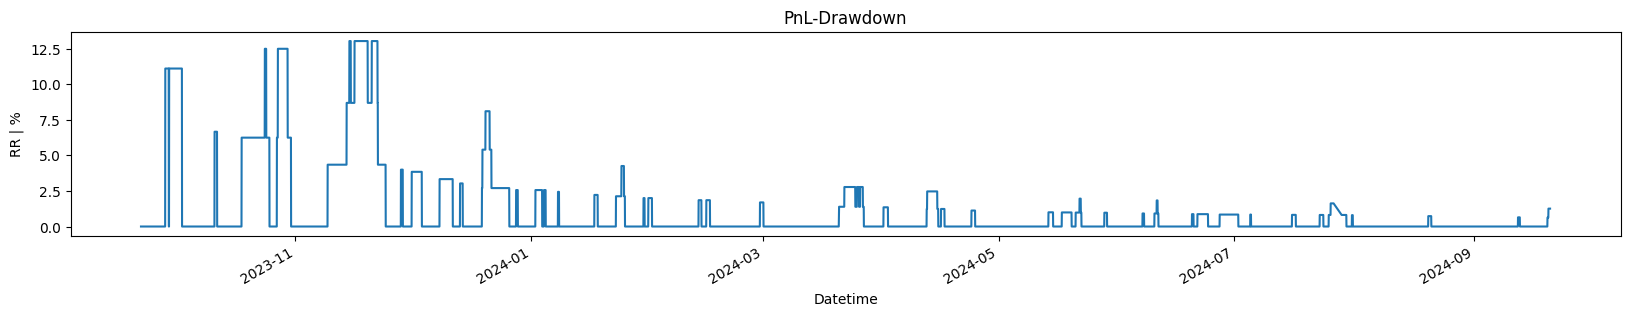

In [16]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / df['Peak']

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)

# import numpy as np
# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(20, 3), 
    title="PnL-Drawdown",
    ylabel="RR | %",
)

In [11]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 13.04 %


> ___________________________________________________________________________________________________________________________________________________________________________________________

# **5. A study on Drawdown**

In [12]:
# [TODO] periods where drawdown (over 50%) happened

# **6. Overview on positions**

<Axes: xlabel='Datetime'>

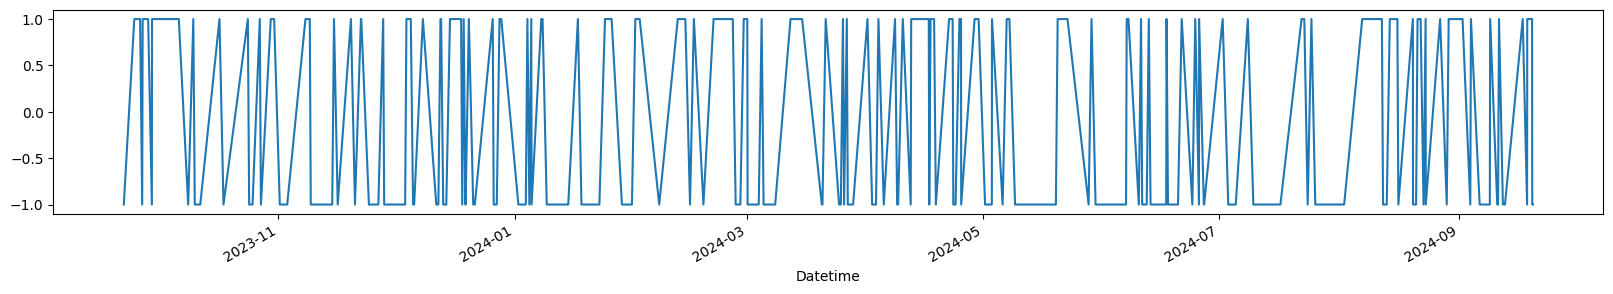

In [13]:
filtrty = df['Position'] != 0

df.loc[filtrty, 'Position'].plot(kind='line', figsize=(20, 3))

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

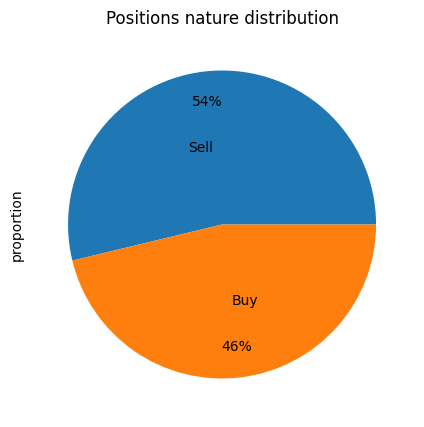

In [14]:
positions_nature_distribution_df = df.loc[filtrty, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

In [15]:
# [TODO] max consecutive wins & losses